Gender Identification

In [ ]:
import os
import random
import joblib
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

In [2]:
BASE_DIR = os.getcwd()   # Notebook-safe base directory
print("BASE_DIR set to:", BASE_DIR)

# Load the CSV file
df = pd.read_csv("sample_indian_names.csv")

BASE_DIR set to: d:\customapps\ECAT\Gender-Classification


In [3]:
def gender_features(name):
    name = name.lower()

    features = {}

    # BASIC FEATURES (keep existing logic)    
    features["first_letter"] = name[0]
    features["last_letter"] = name[-1]
    features["name_length"] = len(name)

    features["ends_with_vowel"] = name[-1] in "aeiou"
    features["ends_with_consonant"] = name[-1] not in "aeiou"
    features["starts_with_vowel"] = name[0] in "aeiou"

    features["last_2"] = name[-2:] if len(name) >= 2 else name
    features["last_3"] = name[-3:] if len(name) >= 3 else name
    
    # INDIAN-SPECIFIC SUFFIX FEATURES    
    female_suffixes = (
        "a", "i", "aa", "ya", "ni", "ika", "ini", "thi", "thra",
        "mitha", "shree", "rani", "latha", "vani", "sri"
    )

    male_suffixes = (
        "n", "an", "esh", "raj", "shan", "kar", "deep", "dev",
        "kumar", "th", "ran", "eshan"
    )

    for suf in female_suffixes:
        features[f"ends_with_female_{suf}"] = name.endswith(suf)

    for suf in male_suffixes:
        features[f"ends_with_male_{suf}"] = name.endswith(suf)

   
    # VOWEL STATISTICS    
    features["vowel_count"] = sum(1 for c in name if c in "aeiou")
    features["vowel_ratio"] = features["vowel_count"] / len(name)    
   
    # Using boundary markers improves learning
    padded = f"<{name}>"

    # 2-grams, 3-grams, 4-grams
    for n in (2, 3, 4):
        for i in range(len(padded) - n + 1):
            gram = padded[i:i+n]
            features[f"char_{n}gram_{gram}"] = True

    return features


Loading sample_indian_names CSV

In [4]:
# Map numeric gender labels to text labels
# 0 -> male, 1 -> female
df["Gender"] = df["Gender"].map({0: "male", 1: "female"})

# Convert to list of (name, gender) tuples
labeled_names = list(zip(df["Name"], df["Gender"]))

# Shuffle the combined data
random.shuffle(labeled_names)

labeled_names[:10]

[('Karmethren', 'male'),
 ('Aasra', 'female'),
 ('Vakshala', 'female'),
 ('Aeyush', 'male'),
 ('Akashya', 'female'),
 ('Tushaara', 'female'),
 ('Vishnudev', 'male'),
 ('Pinkesh', 'male'),
 ('Bela', 'female'),
 ('Renuharshini', 'female')]

In [5]:
# Feature extraction
featuresets = [(gender_features(name), gender) for (name, gender) in labeled_names]

# Shuffle once before splitting
random.shuffle(featuresets)

# Train / Test split (90% train, 10% test)
TOTAL_SIZE = len(featuresets)
TEST_SIZE = int(0.10 * TOTAL_SIZE)

test_set = featuresets[:TEST_SIZE]
train_val_set = featuresets[TEST_SIZE:]

print("Total samples:", TOTAL_SIZE)
print("Training+Validation samples:", len(train_val_set))
print("Test samples:", len(test_set))

# K-Fold Cross Validation on Training data
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42)

cv_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_val_set), 1):

    # Split folds
    train_fold = [train_val_set[i] for i in train_idx]
    val_fold = [train_val_set[i] for i in val_idx]

    X_train = [f for f, y in train_fold]
    y_train = [y for f, y in train_fold]

    X_val = [f for f, y in val_fold]
    y_val = [y for f, y in val_fold]

    # Vectorize features
    vectorizer = DictVectorizer(sparse=True)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_val_vec = vectorizer.transform(X_val)

    # Logistic Regression model
    classifier = LogisticRegression(
        max_iter=1000,
        solver="liblinear",
        class_weight="balanced"
    )

    classifier.fit(X_train_vec, y_train)

    # Validate
    y_pred = classifier.predict(X_val_vec)
    accuracy = accuracy_score(y_val, y_pred)

    cv_accuracies.append(accuracy)
    print(f"Fold {fold} Accuracy: {accuracy:.4f}")

print("\nAverage CV Accuracy:", sum(cv_accuracies) / K)

# Final model training on full training data
X_train_full = [f for f, y in train_val_set]
y_train_full = [y for f, y in train_val_set]

final_vectorizer = DictVectorizer(sparse=True)
X_train_full_vec = final_vectorizer.fit_transform(X_train_full)

final_classifier = LogisticRegression(
    max_iter=1000,
    solver="liblinear",
    class_weight="balanced"
)

final_classifier.fit(X_train_full_vec, y_train_full)

# Final evaluation on Test set
X_test = [f for f, y in test_set]
y_test = [y for f, y in test_set]

X_test_vec = final_vectorizer.transform(X_test)
y_test_pred = final_classifier.predict(X_test_vec)

test_accuracy = accuracy_score(y_test, y_test_pred)
print("Final Test Accuracy:", test_accuracy)

Total samples: 53982
Training+Validation samples: 48584
Test samples: 5398
Fold 1 Accuracy: 0.9303
Fold 2 Accuracy: 0.9334
Fold 3 Accuracy: 0.9217
Fold 4 Accuracy: 0.9309
Fold 5 Accuracy: 0.9294

Average CV Accuracy: 0.9291536357890846
Final Test Accuracy: 0.9353464246017044


Model Stored in BASE_DIR

In [6]:
# Create directory to store model artifacts
os.makedirs("model", exist_ok=True)

# Save trained model and vectorizer
joblib.dump(final_classifier, "model/gender_model.joblib")
joblib.dump(final_vectorizer, "model/vectorizer.joblib")

print("Model and vectorizer saved successfully.")

Model and vectorizer saved successfully.


In [7]:
test_data = labeled_names[:TEST_SIZE]

# Convert test data to DataFrame
test_df = pd.DataFrame(test_data, columns=["Name", "Gender"])

# male -> 0, female -> 1
test_df["Gender"] = test_df["Gender"].map({"male": 0, "female": 1})

# Save to CSV
test_df.to_csv("test_dataset.csv", index=False)

print("Test dataset saved as test_dataset.csv")
print("Total test samples:", len(test_df))

Test dataset saved as test_dataset.csv
Total test samples: 5398


In [8]:
# Predict on test data
y_true = []
y_pred = []

X_test = []
y_test = []

for features, actual_gender in test_set:
    X_test.append(features)
    y_test.append(actual_gender)

# Vectorize test features
X_test_vec = final_vectorizer.transform(X_test)

# Predict
y_pred = final_classifier.predict(X_test_vec)
y_true = y_test

# Test accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print("Test Accuracy:", test_accuracy)


# Confusion matrix (manual)
confusion = Counter()

for actual, predicted in zip(y_true, y_pred):
    confusion[(actual, predicted)] += 1

print("\nConfusion Matrix Counts:")
print("Actual Male -> Predicted Male:", confusion[("male", "male")])
print("Actual Male -> Predicted Female:", confusion[("male", "female")])
print("Actual Female -> Predicted Male:", confusion[("female", "male")])
print("Actual Female -> Predicted Female:", confusion[("female", "female")])

# Show few sample predictions
print("\nSample Predictions (Actual vs Predicted):")
for i in range(10):
    name_features, actual = test_set[i]
    pred = final_classifier.predict(
        final_vectorizer.transform([name_features])
    )[0]

    print(f"{i+1}. Actual: {actual}, Predicted: {pred}")

Test Accuracy: 0.9353464246017044

Confusion Matrix Counts:
Actual Male -> Predicted Male: 2699
Actual Male -> Predicted Female: 223
Actual Female -> Predicted Male: 126
Actual Female -> Predicted Female: 2350

Sample Predictions (Actual vs Predicted):
1. Actual: male, Predicted: male
2. Actual: female, Predicted: female
3. Actual: male, Predicted: male
4. Actual: female, Predicted: female
5. Actual: male, Predicted: male
6. Actual: male, Predicted: male
7. Actual: male, Predicted: male
8. Actual: male, Predicted: male
9. Actual: female, Predicted: female
10. Actual: female, Predicted: female


In [9]:
print("\nSample Predictions (Name | Actual | Predicted):")

for i in range(10):
    name, actual = test_data[i]          # name preserved
    features = gender_features(name)     # dict features

    # Vectorize (VERY IMPORTANT)
    features_vec = final_vectorizer.transform([features])

    # Predict
    predicted = final_classifier.predict(features_vec)[0]

    print(f"{i+1}. Name: {name}, Actual: {actual}, Predicted: {predicted}")


Sample Predictions (Name | Actual | Predicted):
1. Name: Karmethren, Actual: male, Predicted: male
2. Name: Aasra, Actual: female, Predicted: female
3. Name: Vakshala, Actual: female, Predicted: female
4. Name: Aeyush, Actual: male, Predicted: male
5. Name: Akashya, Actual: female, Predicted: female
6. Name: Tushaara, Actual: female, Predicted: female
7. Name: Vishnudev, Actual: male, Predicted: male
8. Name: Pinkesh, Actual: male, Predicted: male
9. Name: Bela, Actual: female, Predicted: female
10. Name: Renuharshini, Actual: female, Predicted: female


In [10]:
def predict_gender_with_unisex(name, threshold=0.80, margin=0.65):
    features = gender_features(name)
    features_vec = final_vectorizer.transform([features])

    probs = final_classifier.predict_proba(features_vec)[0]
    classes = [str(c) for c in final_classifier.classes_]

    prob_dict = {cls: float(prob) for cls, prob in zip(classes, probs)}

    sorted_probs = sorted(prob_dict.items(), key=lambda x: x[1], reverse=True)
    top_label, top_prob = sorted_probs[0]
    second_label, second_prob = sorted_probs[1]

    if top_prob < threshold or (top_prob - second_prob) < margin:
        return {
            "name": name,
            "prediction": "Common",
            "confidence": top_prob,
            "probabilities": prob_dict
        }

    return {
        "name": name,
        "prediction": top_label,
        "confidence": top_prob,
        "probabilities": prob_dict
    }

In [11]:
def store_feedback(name, model_prediction, human_verdict, confidence):
    """
    Stores human feedback in feedback.csv
    """
    file_path = os.path.join(BASE_DIR, "feedback-identification.csv")

    row = pd.DataFrame(
        [[name, model_prediction, human_verdict, confidence]],
        columns=[
            "Name",
            "Model_Prediction",
            "Human_Verdict",
            "Confidence"
        ]
    )

    if os.path.exists(file_path):
        row.to_csv(file_path, mode="a", header=False, index=False)
    else:
        row.to_csv(file_path, index=False)

    print(f"Feedback saved at: {file_path}")

In [12]:
# Name input (single source of truth)
name_input = "juspreet"

# Model prediction
result = predict_gender_with_unisex(name_input)

# Human label
human_verdict = "female"

# Store feedback using the same name
store_feedback(
    name=name_input,
    model_prediction=result["prediction"],
    human_verdict=human_verdict,
    confidence=result["confidence"]
)

Feedback saved at: d:\customapps\ECAT\Gender-Classification\feedback-identification.csv


In [13]:
print(result)

{'name': 'juspreet', 'prediction': 'Common', 'confidence': 0.7367576866935183, 'probabilities': {'female': 0.26324231330648173, 'male': 0.7367576866935183}}


Building the new model_v2 version of model_v1 for training the model on the feedback set.

In [ ]:
# CELL 1: Initialize v2 from v1
BASE_DIR = os.getcwd()
MODEL_DIR = os.path.join(BASE_DIR, "model")
os.makedirs(MODEL_DIR, exist_ok=True)

MODEL_V1_PATH = os.path.join(MODEL_DIR, "gender_model.joblib")
MODEL_V2_PATH = os.path.join(MODEL_DIR, "gender_model_v2.joblib")
VECTORIZER_PATH = os.path.join(MODEL_DIR, "vectorizer.joblib")

# Load v1 artifacts
v1_model = joblib.load(MODEL_V1_PATH)
vectorizer = joblib.load(VECTORIZER_PATH)

print("Loaded v1 model & vectorizer")

# Create v2 with SAME configuration
v2_model = LogisticRegression(
    max_iter=1000,
    solver="liblinear",
    class_weight="balanced",
    warm_start=True
)

# Copy learned parameters
v2_model.classes_ = v1_model.classes_
v2_model.coef_ = np.copy(v1_model.coef_)
v2_model.intercept_ = np.copy(v1_model.intercept_)
v2_model.n_features_in_ = v1_model.n_features_in_

# Save v2
joblib.dump(v2_model, MODEL_V2_PATH)

print("v2 initialized from v1 (weights copied)")
print("v1:", MODEL_V1_PATH)
print("v2:", MODEL_V2_PATH)


✅ Loaded v1 model & vectorizer
✅ v2 initialized from v1 (weights copied)
v1: d:\customapps\ECAT\Gender-Classification\model\gender_model.joblib
v2: d:\customapps\ECAT\Gender-Classification\model\gender_model_v2.joblib


In [ ]:
# Incremental Retraining from Feedback
BASE_DIR = os.getcwd()
MODEL_DIR = os.path.join(BASE_DIR, "model")

MODEL_V2_PATH = os.path.join(MODEL_DIR, "gender_model_v2.joblib")
VECTORIZER_PATH = os.path.join(MODEL_DIR, "vectorizer.joblib")
FEEDBACK_PATH = os.path.join(BASE_DIR, "feedback-identification.csv")

# Load v2 model & vectorizer
model = joblib.load(MODEL_V2_PATH)
vectorizer = joblib.load(VECTORIZER_PATH)

print("Loaded v2 model for incremental training")

# Feature extractor 
def gender_features(name):
    name = name.lower()
    return {
        "last_letter": name[-1],
        "first_letter": name[0],
        "name_length": len(name),
        "suffix_2": name[-2:],
        "suffix_3": name[-3:],
        "prefix_2": name[:2],
        "prefix_3": name[:3]
    }

# Load feedback
df = pd.read_csv(FEEDBACK_PATH)

# Only rows with valid human verdict
df = df[df["Human_Verdict"].isin(["male", "female", "common"])]

print("Feedback rows used:", len(df))

# Build weighted training set
X_features = []
y_labels = []

for _, row in df.iterrows():

    label = row["Human_Verdict"]

    correct_count = row.get(label, 0)
    correct_count = 0 if pd.isna(correct_count) else int(correct_count)

    weight = max(correct_count, 1)

    for _ in range(weight):
        X_features.append(gender_features(row["Name"]))
        y_labels.append(label)

print("\nLabel distribution used for training:")
print(Counter(y_labels))

# Vectorize
X_vec = vectorizer.transform(X_features)
y = y_labels

# Incremental retraining (CONTINUES LEARNING)
model.fit(X_vec, y)

# Save updated v2
joblib.dump(model, MODEL_V2_PATH)

print("\nv2 model updated incrementally using feedback")
print("Model path:", MODEL_V2_PATH)


 Loaded v2 model for incremental training
Feedback rows used: 128

Label distribution used for training:
Counter({'male': 68, 'female': 57, 'common': 5})

v2 model updated incrementally using feedback
Model path: d:\customapps\ECAT\Gender-Classification\model\gender_model_v2.joblib


C:\Users\swapnil_singh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Accuracy Comparison: model_v1 vs model_v2

In [17]:
# Paths
BASE_DIR = os.getcwd()
MODEL_DIR = os.path.join(BASE_DIR, "model")

MODEL_V1_PATH = os.path.join(MODEL_DIR, "gender_model.joblib")
MODEL_V2_PATH = os.path.join(MODEL_DIR, "gender_model_v2.joblib")
VECTORIZER_PATH = os.path.join(MODEL_DIR, "vectorizer.joblib")
FEEDBACK_PATH = os.path.join(BASE_DIR, "feedback-identification.csv")

# Load models & vectorizer
model_v1 = joblib.load(MODEL_V1_PATH)
model_v2 = joblib.load(MODEL_V2_PATH)
vectorizer = joblib.load(VECTORIZER_PATH)
print("Loaded v1 and v2 models")

# Feature extractor (same as training)
def gender_features(name):
    name = name.lower()
    return {
        "last_letter": name[-1],
        "first_letter": name[0],
        "name_length": len(name),
        "suffix_2": name[-2:],
        "suffix_3": name[-3:],
        "prefix_2": name[:2],
        "prefix_3": name[:3]
    }

# Accuracy on ORIGINAL TEST SET (Before Feedback)
X_test = [features for features, _ in test_set]
y_test = [label for _, label in test_set]

X_test_vec = vectorizer.transform(X_test)

y_test_pred_v1 = model_v1.predict(X_test_vec)
y_test_pred_v2 = model_v2.predict(X_test_vec)

acc_test_v1 = accuracy_score(y_test, y_test_pred_v1)
acc_test_v2 = accuracy_score(y_test, y_test_pred_v2)

print("\nTest Set Accuracy:")
print("v1 (Before Feedback):", round(acc_test_v1, 4))
print("v2 (After Feedback): ", round(acc_test_v2, 4))


# Accuracy on FEEDBACK DATA (Human Truth)
feedback_df = pd.read_csv(FEEDBACK_PATH)

X_feedback = [gender_features(name) for name in feedback_df["Name"]]
y_feedback = feedback_df["Human_Verdict"].tolist()

X_feedback_vec = vectorizer.transform(X_feedback)

y_feedback_pred_v1 = model_v1.predict(X_feedback_vec)
y_feedback_pred_v2 = model_v2.predict(X_feedback_vec)

acc_feedback_v1 = accuracy_score(y_feedback, y_feedback_pred_v1)
acc_feedback_v2 = accuracy_score(y_feedback, y_feedback_pred_v2)

print("\nFeedback Data Accuracy (Human Verdict):")
print("v1 (Before Feedback):", round(acc_feedback_v1, 4))
print("v2 (After Feedback): ", round(acc_feedback_v2, 4))



Loaded v1 and v2 models

Test Set Accuracy:
v1 (Before Feedback): 0.9353
v2 (After Feedback):  0.8073

Feedback Data Accuracy (Human Verdict):
v1 (Before Feedback): 0.5
v2 (After Feedback):  0.7879


In [18]:
ACCURACY_CSV_PATH = os.path.join(BASE_DIR, "model_accuracy_comparison.csv")

accuracy_df = pd.DataFrame(
    [
        ["Test", "v1", acc_test_v1],
        ["Test", "v2", acc_test_v2],
        ["Feedback", "v1", acc_feedback_v1],
        ["Feedback", "v2", acc_feedback_v2],
    ],
    columns=["Dataset", "Model_Version", "Accuracy"]
)

# Append to CSV if exists, else create new
if os.path.exists(ACCURACY_CSV_PATH):
    accuracy_df.to_csv(ACCURACY_CSV_PATH, mode="a", header=False, index=False)
else:
    accuracy_df.to_csv(ACCURACY_CSV_PATH, index=False)

print("\nAccuracy comparison appended to CSV")
print("File path:", ACCURACY_CSV_PATH)



Accuracy comparison appended to CSV
File path: d:\customapps\ECAT\Gender-Classification\model_accuracy_comparison.csv


Bar Chart representation of Both Models Accuracies

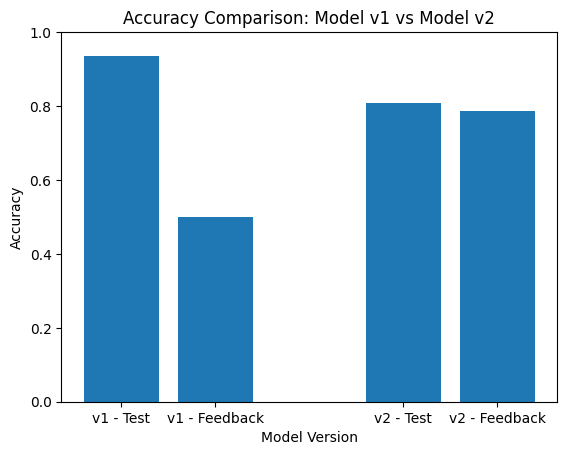

In [ ]:
# Accuracy values (already computed earlier)
accuracies = [
    acc_test_v1,
    acc_feedback_v1,
    acc_test_v2,
    acc_feedback_v2
]

# X positions (gap between v1 and v2)
x_positions = [0, 1, 3, 4]

# Labels
labels = [
    "v1 - Test",
    "v1 - Feedback",
    "v2 - Test",
    "v2 - Feedback"
]

# Plot
plt.figure()
plt.bar(x_positions, accuracies)
plt.xticks(x_positions, labels)
plt.ylabel("Accuracy")
plt.xlabel("Model Version")
plt.title("Accuracy Comparison: Model v1 vs Model v2")
plt.ylim(0, 1)

plt.show()


For Dyanamic Chart(Data directly from the model_accuracy_comparison.csv)

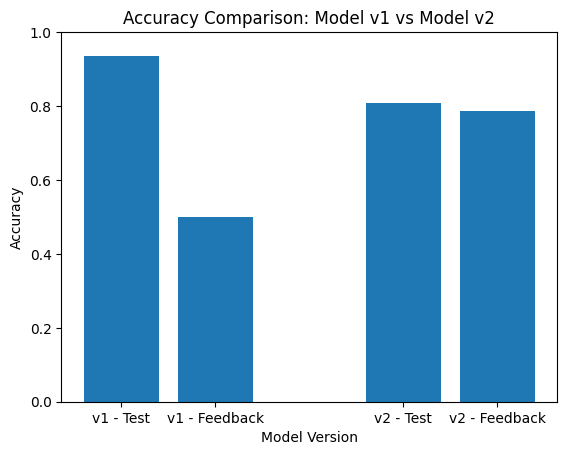

In [20]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# CSV path
BASE_DIR = os.getcwd()
ACCURACY_CSV_PATH = os.path.join(BASE_DIR, "model_accuracy_comparison.csv")

# Load accuracy history
accuracy_df = pd.read_csv(ACCURACY_CSV_PATH)

# Take latest entry for each Dataset + Model
latest_df = (
    accuracy_df
    .groupby(["Dataset", "Model_Version"], as_index=False)
    .last()
)

# Extract accuracies dynamically
acc_test_v1 = latest_df[
    (latest_df["Dataset"] == "Test") & (latest_df["Model_Version"] == "v1")
]["Accuracy"].values[0]

acc_feedback_v1 = latest_df[
    (latest_df["Dataset"] == "Feedback") & (latest_df["Model_Version"] == "v1")
]["Accuracy"].values[0]

acc_test_v2 = latest_df[
    (latest_df["Dataset"] == "Test") & (latest_df["Model_Version"] == "v2")
]["Accuracy"].values[0]

acc_feedback_v2 = latest_df[
    (latest_df["Dataset"] == "Feedback") & (latest_df["Model_Version"] == "v2")
]["Accuracy"].values[0]

# Prepare plot data
accuracies = [
    acc_test_v1,
    acc_feedback_v1,
    acc_test_v2,
    acc_feedback_v2
]

# Spacing between v1 and v2 groups
x_positions = [0, 1, 3, 4]

labels = [
    "v1 - Test",
    "v1 - Feedback",
    "v2 - Test",
    "v2 - Feedback"
]


# Plot bar chart
plt.figure()
plt.bar(x_positions, accuracies)
plt.xticks(x_positions, labels)
plt.ylabel("Accuracy")
plt.xlabel("Model Version")
plt.title("Accuracy Comparison: Model v1 vs Model v2")
plt.ylim(0, 1)

plt.show()
